### H-IQL usage on Minari Inverted Pendulum 
This notebook shows how to apply Hybrid Implicit Q-Learning on the Minari Inverted Pendulum Dataset. This has been used as a proof-of-concept for the alogrithm. (https://minari.farama.org/main/datasets/mujoco/invertedpendulum/medium-v0/)

In [10]:
import minari
import numpy as np
import importlib

dataset = minari.load_dataset('mujoco/invertedpendulum/medium-v0')
eval_env = dataset.recover_environment(eval_env=True)

obs, _ = eval_env.reset()
print("Env loaded successfully. Obs shape:", obs.shape)

Env loaded successfully. Obs shape: (4,)


/home/rasmno20/.local/lib/python3.10/site-packages/minari/dataset/minari_dataset.py:204: UserWarning: Installed mujoco version 3.1.6 does not meet the requirement ==3.2.3.
We recommend to install the required version with `pip install "mujoco==3.2.3"`
  warnings.warn(


### Separate the transitions into states, actions, rewards, next states, and terminals. 

In [11]:
states = []
actions = []
rewards = []
next_states = []
terminals = []

for ep in dataset.iterate_episodes():
    for t in range(len(ep.rewards)):
        obs = ep.observations[t]
        next_obs = ep.observations[t + 1]

        states.append(obs)
        actions.append(ep.actions[t])
        rewards.append(ep.rewards[t])
        next_states.append(next_obs)
        terminals.append(ep.terminations[t])
    terminals[-1] = 1.0

states = np.array(states)
actions = np.array(actions)
rewards = np.array(rewards)
next_states = np.array(next_states)
terminals = np.array(terminals)

### Modify into a hybrid action space
Originally there is only one action in this dataset which is the one-dimensional force. However, the dataset is modified into a hyrbid action space consiting of a discrete decision, Left or Right, followed by an unsigned force (Continuous).

In [12]:
hybrid_actions = []

for action in actions:
    discrete_action = np.zeros(2)

    if action > 0:  
        discrete_action[0] = 1
    else:  
        discrete_action[1] = 1

    hybrid_action = np.concatenate([action, discrete_action])

    hybrid_actions.append(hybrid_action)

hybrid_actions = np.array(hybrid_actions)

### Scaling and Replay Buffer
While this dataset does not neccessarily need sccaling, it is a good practice and most other datasets benefits from it. It is important that all features which needs scaling are placed in the first part of the states and action vectors, as the logic in the model is built around that thought. 

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import HIQL as classes
importlib.reload(classes)

capacity = states.shape[0]
obs_dim = states.shape[1]
act_dim = hybrid_actions.shape[1]

obs_scaler = StandardScaler()
action_scaler = MinMaxScaler(feature_range=(-1, 1))
reward_scaler = StandardScaler()

# Fit on raw data
obs_scaler.fit(states)      
continuous_part = hybrid_actions[:, :1]
action_scaler.fit(continuous_part)          
reward_scaler.fit(rewards.reshape(-1, 1))

# Transform data
states_scaled = obs_scaler.transform(states)
next_states_scaled = obs_scaler.transform(next_states)
continuous_scaled = action_scaler.transform(continuous_part)
rewards_scaled = reward_scaler.transform(rewards.reshape(-1, 1)).flatten()

hybrid_actions_scaled = np.concatenate([continuous_scaled, hybrid_actions[:, 1:]], axis=1)

buffer = classes.ReplayBuffer(capacity=capacity, observation_shape=(obs_dim,), action_dim=act_dim)

for s, a, r, ns, done in zip(states_scaled, hybrid_actions_scaled, rewards_scaled, next_states_scaled, terminals):
    buffer.add(s, a, r, ns, done)

print(capacity)

Updated
99075


### Create the H-IQL networks
There are more hyperparameters such as zeta included in the class that can be set here. 

In [14]:
import HIQL as classes
importlib.reload(classes)

obs_dim = states.shape[-1]
act_dim = hybrid_actions.shape[-1]
continuous_dim = 1
discrete_dim = act_dim - continuous_dim
hidden_dims = [256, 256]
device = 'cpu'

model = classes.HIQLModel(observation_dim=obs_dim, discrete_dim=discrete_dim, continuous_dim=continuous_dim, 
                         hidden_dims=hidden_dims, device=device, expectile=0.7, weight_temp=3.0, gamma=0.99, 
                         observation_scaler=obs_scaler, action_scaler=action_scaler, reward_scaler=reward_scaler)

print(f'Buffer size: {states.shape[0]}')
print(f'obs_dim: {obs_dim}, act_dim: {act_dim}')
print("Action range:", hybrid_actions.min(), hybrid_actions.max())
print("Obs range:", states.min(), states.max())

Buffer size: 99075
obs_dim: 4, act_dim: 3
Action range: -2.9883339405059814 2.982673168182373
Obs range: -3.3845583766881124 3.157297275462821


### Custom evaluation on the environment

In [15]:
def evaluate_policy(policy, env, n_episodes=100):
    returns = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = policy(obs) 
            obs, reward, terminated, truncated, _ = env.step(action[0].flatten())
            total_reward += reward
            done = terminated or truncated
        returns.append(total_reward)
    return returns

### Training the model
In a simple environment like this, 30000 traning steps is more than enough to find the optimal policy.

In [16]:
from tqdm import trange
import time
    
num_training_steps = 30000
batch_size = 256
num_critic_steps_per_actor = 1  
update_interval = 100      

start_time = time.time()
pbar = trange(num_training_steps, desc="Training", leave=True)
history = {}
eval_dict = {}

for step in pbar:
    batch = buffer.sample(batch_size)
    
    critic_info = model.update_critic_value(batch)

    actor_info = model.update_actor(batch)
    model.actor_lr_schedule.step()

    losses = {**critic_info, **actor_info}
    
    if step % 2000 == 0:
            returns = evaluate_policy(model.predict, eval_env, n_episodes=10)
            eval_dict[step] = np.mean(returns)
            print(f'{step}: {np.mean(returns)}')

    if step % update_interval == 0:
        elapsed = time.time() - start_time
        history[step] = losses
        pbar.set_postfix({
            "Time": f"{elapsed:.2f}s",
            "Q Loss": f"{losses['q_loss']:.4f}",
            "Value Loss": f"{losses['value_loss']:.4f}",
            "Actor Loss": f"{losses['actor_loss']:.4f}",
        })

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Training:   0%|          | 4/30000 [00:01<2:08:24,  3.89it/s, Time=1.22s, Q Loss=2.3863, Value Loss=0.0107, Actor Loss=0.7430] 

0: 85.2


Training:   7%|▋         | 2008/30000 [00:54<42:24, 11.00it/s, Time=54.03s, Q Loss=0.0297, Value Loss=0.0029, Actor Loss=0.3655]

2000: 127.1


Training:  13%|█▎        | 4008/30000 [01:49<41:09, 10.52it/s, Time=109.17s, Q Loss=0.0507, Value Loss=0.0049, Actor Loss=-0.0105]

4000: 119.7


Training:  20%|██        | 6007/30000 [02:43<45:57,  8.70it/s, Time=163.40s, Q Loss=0.0285, Value Loss=0.0057, Actor Loss=-0.1466]  

6000: 155.5


Training:  27%|██▋       | 8004/30000 [03:37<1:03:35,  5.77it/s, Time=217.78s, Q Loss=0.0149, Value Loss=0.0130, Actor Loss=-0.0878]

8000: 158.8


Training:  33%|███▎      | 10005/30000 [04:38<1:04:59,  5.13it/s, Time=278.31s, Q Loss=0.0197, Value Loss=0.0160, Actor Loss=-0.0902]

10000: 495.2


Training:  40%|████      | 12004/30000 [05:37<1:31:47,  3.27it/s, Time=337.44s, Q Loss=0.0377, Value Loss=0.0168, Actor Loss=-0.0594]

12000: 363.6


Training:  47%|████▋     | 14005/30000 [06:44<2:45:06,  1.61it/s, Time=404.44s, Q Loss=0.0208, Value Loss=0.0183, Actor Loss=-0.1283]

14000: 1000.0


Training:  53%|█████▎    | 16008/30000 [07:48<2:15:54,  1.72it/s, Time=468.73s, Q Loss=0.0151, Value Loss=0.0363, Actor Loss=-0.1468]

16000: 1000.0


Training:  60%|██████    | 18005/30000 [08:57<1:13:48,  2.71it/s, Time=537.75s, Q Loss=0.0282, Value Loss=0.0356, Actor Loss=-0.1371]

18000: 1000.0


Training:  67%|██████▋   | 20004/30000 [10:03<1:32:14,  1.81it/s, Time=603.01s, Q Loss=0.0089, Value Loss=0.0326, Actor Loss=-0.1792]

20000: 1000.0


Training:  73%|███████▎  | 22008/30000 [11:09<1:27:45,  1.52it/s, Time=668.86s, Q Loss=0.0111, Value Loss=0.0358, Actor Loss=-0.1701]

22000: 1000.0


Training:  80%|████████  | 24006/30000 [12:12<57:56,  1.72it/s, Time=732.27s, Q Loss=0.0185, Value Loss=0.0400, Actor Loss=-0.3661]  

24000: 1000.0


Training:  87%|████████▋ | 26005/30000 [13:16<40:00,  1.66it/s, Time=796.89s, Q Loss=0.0120, Value Loss=0.0550, Actor Loss=-0.2125]

26000: 1000.0


Training:  93%|█████████▎| 28006/30000 [14:23<19:53,  1.67it/s, Time=863.50s, Q Loss=0.0100, Value Loss=0.0371, Actor Loss=-0.1176]

28000: 1000.0


Training: 100%|██████████| 30000/30000 [15:15<00:00, 32.75it/s, Time=913.33s, Q Loss=0.0239, Value Loss=0.0333, Actor Loss=-0.1618]


### Final evaluation of of the model in the environment

In [18]:
model.policy.eval()
returns = evaluate_policy(model.predict, eval_env, 100)
mean_return = np.mean(returns)

print(f"Average return: {mean_return:.2f}")

Average return: 1000.00


### Plotting the losses over the 30000 training steps

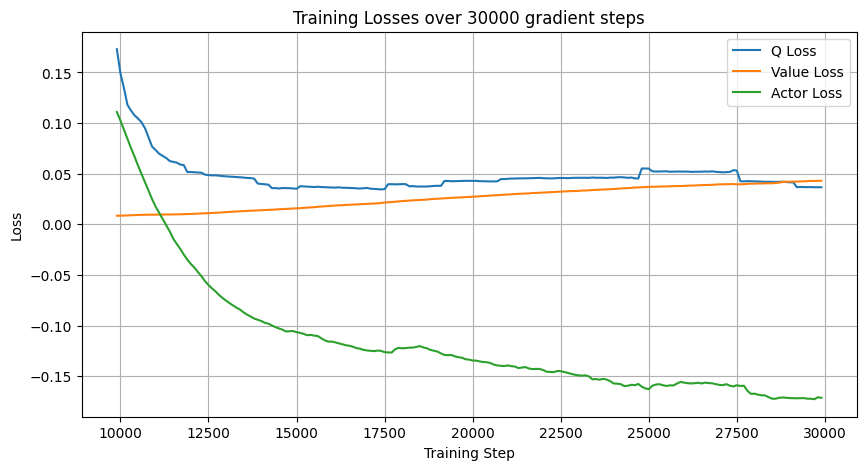

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_data(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

steps = sorted(history.keys())
q_losses   = [history[s]['q_loss']   for s in steps]
v_losses   = [history[s]['value_loss'] for s in steps]
pi_losses  = [history[s]['actor_loss'] for s in steps]

window_size = 100
q_losses_smooth = smooth_data(q_losses, window_size)
v_losses_smooth = smooth_data(v_losses, window_size)
pi_losses_smooth = smooth_data(pi_losses, window_size)

smoothed_steps = steps[window_size-1:]

plt.figure(figsize=(10,5))
plt.plot(smoothed_steps, q_losses_smooth,  label='Q Loss')
plt.plot(smoothed_steps, v_losses_smooth,  label='Value Loss')
plt.plot(smoothed_steps, pi_losses_smooth, label='Actor Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Losses over 30000 gradient steps')
plt.legend()
plt.grid(True)
plt.show()
